In [1]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd

import warnings; warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from pathlib import Path
DATA_PATH = Path("./data/")
OUTPUT_PATH = Path("./output/")

# General settings
SEED = 42
N_FOLDS = 5

# Metric choice placeholder
#Adjust depending on the competition
METRIC = "auc"

In [3]:
#Load Data
df = pd.read_csv(DATA_PATH / "Spaceship Titanic" / "train.csv")

In [4]:
## Because our LB score (0,79331) is strongly different from the CV score, let`s start THE LEAKAGE BATTLE
#Leakage battle
#Let`s break on fold, then preprocess

target_col = "Transported"
use_cols = ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
numeric_features = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
categorical_features = ['HomePlanet','CryoSleep','Cabin','Destination','VIP']
X=df[use_cols].copy() 
y = df[target_col].astype(int).copy()

In [5]:
numeric_transformer = Pipeline([("imputer", SimpleImputer(strategy = "median"))])

categorical_transformer = Pipeline([("imputer", SimpleImputer(strategy = "most_frequent")),
                                   ("onehot", OneHotEncoder(handle_unknown="ignore"))
                                   ])
preprocessor = ColumnTransformer([("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = []

for train_idx, val_idx in kf.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = Pipeline([
        ("prep", preprocessor),
        ("lgbm", LGBMClassifier(n_estimators=100, 
                                num_leaves=16,
                                max_depth=4,
                                min_data_in_leaf=20,
                                feature_fraction=0.7,
                                bagging_fraction=0.7,
                                learning_rate=0.05,
                                random_state=42,n_jobs=-1,verbosity = -1))
    ])

    model.fit(X_train, y_train)
    preds = model.predict_proba(X_val)[:,1]
    scores.append(roc_auc_score(y_val, preds))

print(sum(scores)/len(scores))

0.8753761902494295


Text(0.5, 1.0, 'Triangle correlation heatmap')

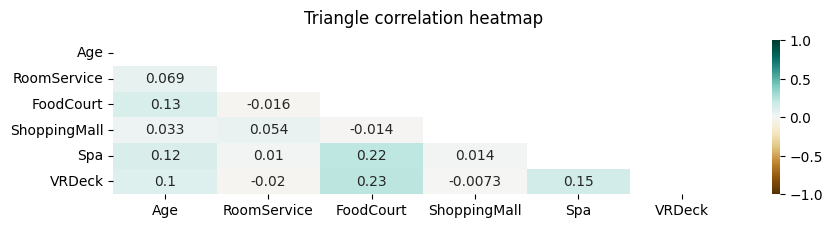

In [6]:
#Check for correlation

cor_matrix = X.drop(columns = categorical_features).corr()
mask = np.triu(np.ones_like(cor_matrix, dtype = "bool"))
plt.figure(figsize = (10,2))
heatmap = sns.heatmap(cor_matrix, mask = mask, annot=True, vmin = -1, vmax = 1, cmap='BrBG')
heatmap.set_title('Triangle correlation heatmap', fontdict={'fontsize':12}, pad=12)

In [7]:
#Remove Spa and VRDeck coulumns, as highly correlated with FoodCourt
target_col = "Transported"
use_cols = ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall']
numeric_features = ['Age','RoomService','FoodCourt','ShoppingMall']
categorical_features = ['HomePlanet','CryoSleep','Cabin','Destination','VIP']
X=df[use_cols].copy() 
y = df[target_col].astype(int).copy()

In [8]:
numeric_transformer = Pipeline([("imputer", SimpleImputer(strategy = "median"))])

categorical_transformer = Pipeline([("imputer", SimpleImputer(strategy = "most_frequent")),
                                   ("onehot", OneHotEncoder(handle_unknown="ignore"))
                                   ])
preprocessor = ColumnTransformer([("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = []

for train_idx, val_idx in kf.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = Pipeline([
        ("prep", preprocessor),
        ("lgbm", LGBMClassifier(n_estimators=100, 
                                num_leaves=16,
                                max_depth=4,
                                min_data_in_leaf=20,
                                feature_fraction=0.7,
                                bagging_fraction=0.7,
                                learning_rate=0.05,
                                random_state=42,n_jobs=-1,verbosity = -1))
    ])

    model.fit(X_train, y_train)
    preds = model.predict_proba(X_val)[:,1]
    scores.append(roc_auc_score(y_val, preds))

print(sum(scores)/len(scores))

0.8469004162575521
